In [47]:
import datetime
import re

def clean_issue_data(data):
    # Cleaning Labels
    data['labels'] = [label.strip() for label in data.get('labels', [])]
    
    # Converting creation_date to datetime object
    if 'creation_date' in data and data['creation_date']:
        # Remove 'Z' and convert
        data['creation_date'] = datetime.datetime.fromisoformat(data['creation_date'].replace('Z', '')).replace(tzinfo=datetime.timezone.utc)
    
    # Cleaning Body
    if 'body' in data and data['body']:
        # Convert to lowercase
        data['body'] = data['body'].lower()
        
        # Remove URLs
        data['body'] = re.sub(r'http\S+', '', data['body'])
        

    # Removing unwanted keys like 'download_timeout', 'download_slot'.
    unwanted_keys = ['depth', 'download_timeout', 'download_slot', 'download_latency']
    for key in unwanted_keys:
        data.pop(key, None)

    return data



In [48]:
# Open the file with UTF-8 encoding
with open('./issues.json', 'r', encoding='utf-8') as file:
    issues = json.load(file)

# Clean each issue
cleaned_issues = [clean_issue_data(issue) for issue in issues]

# Convert cleaned issues to a DataFrame
df_issues = pd.DataFrame(cleaned_issues)

# Now, df_issues contains the cleaned issues in a DataFrame format
print(df_issues.head())


                                               title  \
0     Rails 7.0.7 regression collection caching JSON   
1  ActiveRecord - Dependent destroy relies on cac...   
2  Regression in Postgres aggregate function data...   
3  Upgrading to Rails 7.0 changes precision when ...   
4  Webdrivers::VersionError: Unable to find lates...   

                                          link  \
0  https://github.com/rails/rails/issues/48979   
1  https://github.com/rails/rails/issues/48968   
2  https://github.com/rails/rails/issues/48946   
3  https://github.com/rails/rails/issues/48965   
4  https://github.com/rails/rails/issues/48973   

                                              labels  \
0                                                 []   
1                                                 []   
2            [activerecord, With reproduction steps]   
3  [activerecord, attached PR, With reproduction ...   
4                [railties, With reproduction steps]   

              creation_da

1.	How do the number of issues evolve over time?

In [49]:
df_issues['creation_date'] = pd.to_datetime(df_issues['creation_date'])


In [38]:
# Sort the DataFrame by 'created_at'
df_issues_sorted = df_issues.sort_values('creation_date')

In [39]:
# Create a cumulative count of issues over time
df_issues_sorted['cumulative_count'] = range(1, len(df_issues_sorted) + 1)
df_issues_sorted['cumulative_count']

401      1
399      2
403      3
404      4
400      5
      ... 
1      401
4      402
5      403
7      404
0      405
Name: cumulative_count, Length: 405, dtype: int64

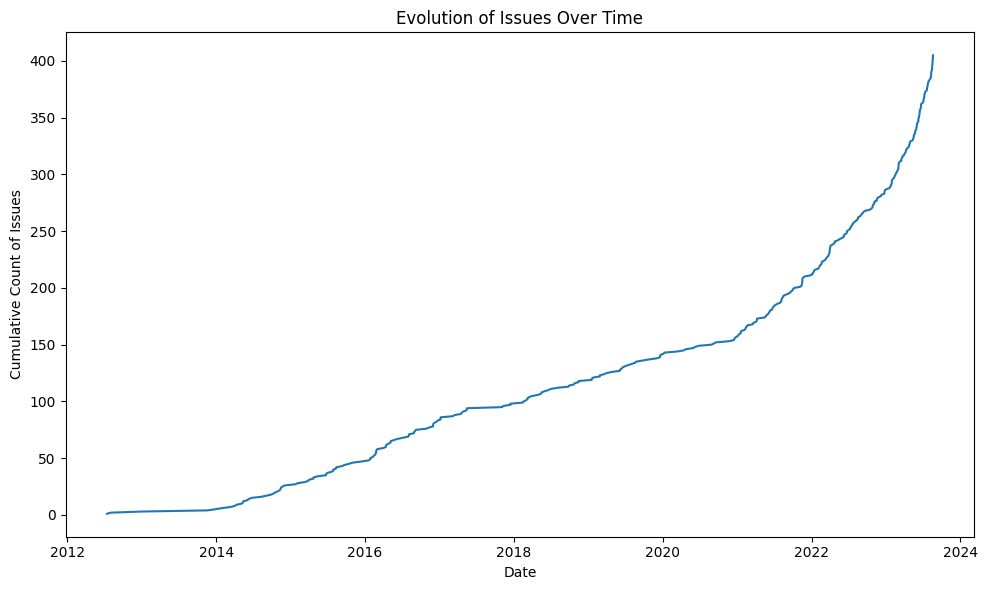

In [40]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_issues_sorted['creation_date'], df_issues_sorted['cumulative_count'])
plt.xlabel('Date')
plt.ylabel('Cumulative Count of Issues')
plt.title('Evolution of Issues Over Time')
plt.tight_layout()
plt.show()

In [12]:
monthly_issues = df_issues.resample('M', on='creation_date').size()


In [13]:
daily_issues = df_issues.resample('D', on='creation_date').size()


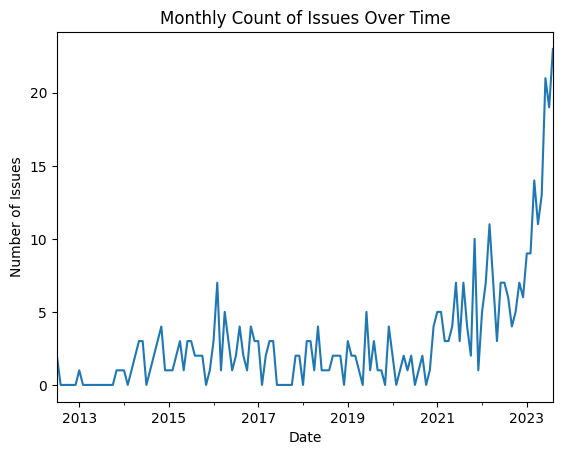

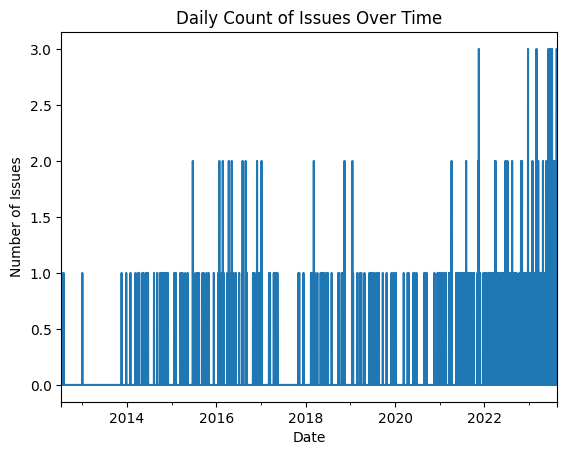

In [14]:
# For monthly issues
monthly_issues.plot()
plt.title('Monthly Count of Issues Over Time')
plt.ylabel('Number of Issues')
plt.xlabel('Date')
plt.show()

# For daily issues
daily_issues.plot()
plt.title('Daily Count of Issues Over Time')
plt.ylabel('Number of Issues')
plt.xlabel('Date')
plt.show()


2.	Are there any periods in which we get more issues?

In [41]:
df2_issues=df_issues.copy()
# Setting the 'creation_date' as the index of the dataframe
df2_issues.set_index('creation_date', inplace=True)

In [42]:
# Resampling the data on a monthly basis and count the number of issues
monthly_issues = df2_issues.resample('M').size()

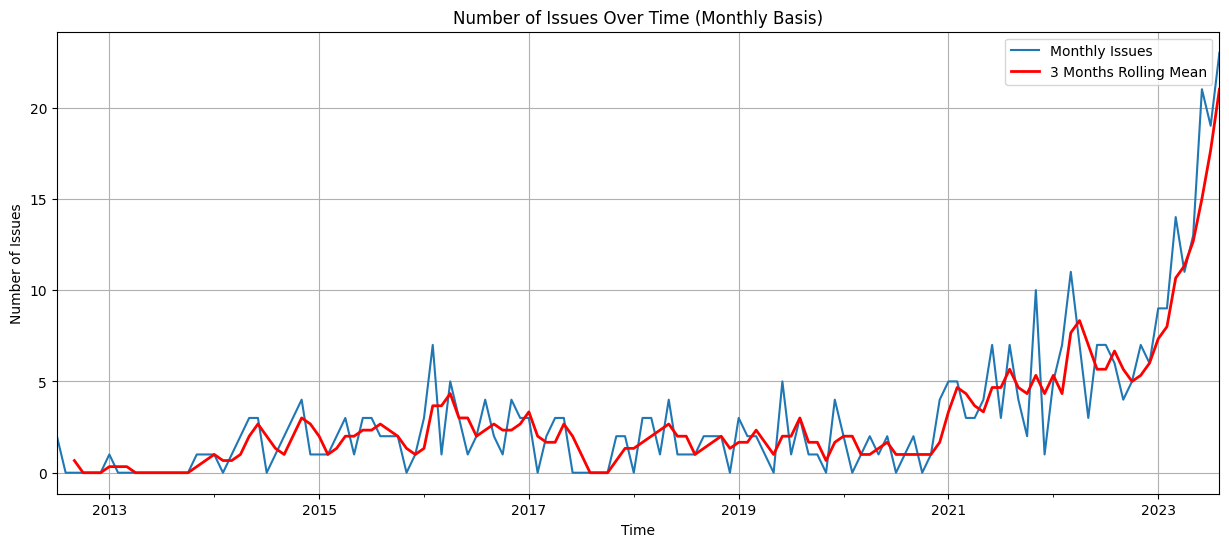

In [43]:
# Plotting
plt.figure(figsize=(15, 6))
monthly_issues.plot(label="Monthly Issues")
monthly_issues.rolling(window=3).mean().plot(color='red', linewidth=2, label="3 Months Rolling Mean")
plt.title('Number of Issues Over Time (Monthly Basis)')
plt.ylabel('Number of Issues')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
df_issues['month'] = df_issues['creation_date'].dt.month

# Grouping by month and calculating the mean number of issues
monthly_avg_issues = df_issues.groupby('month').size()

# Sorting to find months with the highest average issues
sorted_months = monthly_avg_issues.sort_values(ascending=True)

print(sorted_months)


month
10    16
9     19
12    23
11    31
1     33
2     34
5     35
4     38
7     38
3     40
8     48
6     50
dtype: int64


3.	Is there anyone who reports more issues than others?

In [65]:
# Create a copy of the dataframe
df_copy = df_issues.copy()

# Now, to find out who reports more issues than others:
author_counts = df_copy['issue_submitter'].value_counts().sort_values(ascending=False)

# Display the top reporters
top_reporters = author_counts.head(10)

print(top_reporters)

dhh               5
georgeclaghorn    4
khiav223577       3
shouichi          3
matthewd          3
maximerety        3
jeremy            3
grosser           2
tenderlove        2
aglushkov         2
Name: issue_submitter, dtype: int64


4.	What is the most popular category (label)? 

In [66]:
# First, we'll explode the labels so each label gets its own row
label_counts = df_issues.explode('labels')['labels'].value_counts()

# Print the label with the most issues
most_popular_label = label_counts.idxmax()
most_popular_count = label_counts.max()

print(f"The most popular label is '{most_popular_label}' with {most_popular_count} issues.")


The most popular label is 'activerecord' with 198 issues.


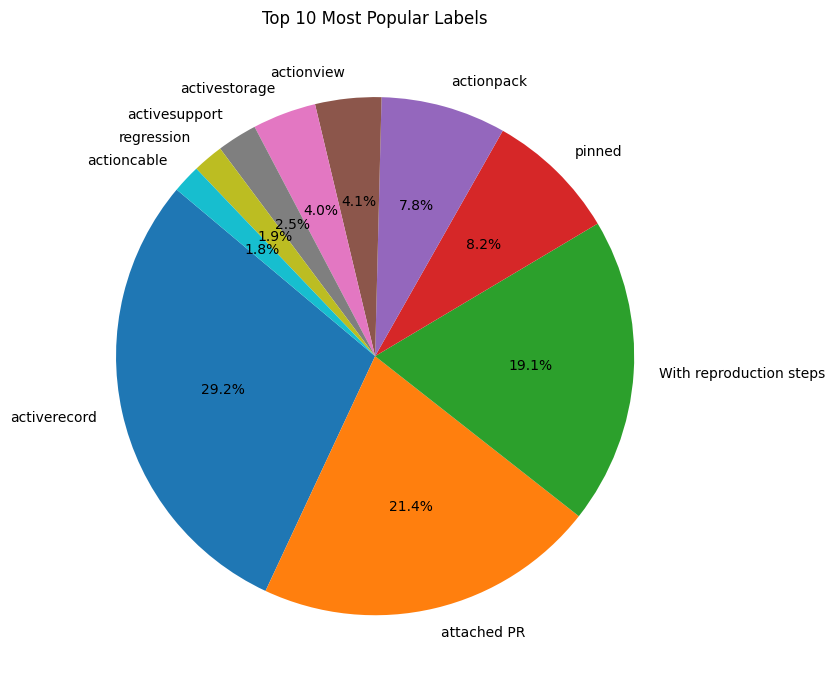

In [78]:
# Taking the top 10 labels for visualization
top_labels = label_counts.head(10)

# Plotting
plt.figure(figsize=(10, 7))
top_labels.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Most Popular Labels')
plt.ylabel('')  # To remove the 'labels' ylabel produced by default
plt.tight_layout()
plt.show()

5.	Classifying the issues 

In [69]:
# Extracting the first label for each issue
df_issues['single_label'] = df_issues['labels'].apply(lambda x: x[0] if x else None)

# Filtering out issues that don't have any labels or descriptions
filtered_issues = df_issues.dropna(subset=['single_label', 'body'])

descriptions = filtered_issues['body'].tolist()
# Extracting all unique labels
unique_labels = filtered_issues['single_label'].unique()

# Creating a mapping from label to integer
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_mapping[label] for label in filtered_issues['single_label'].tolist()]



# Splitting data into training and validation sets (for simplicity, doing a 80-20 split here)
train_texts, train_labels = descriptions[:int(0.8*len(descriptions))], labels[:int(0.8*len(labels))]
val_texts, val_labels = descriptions[int(0.8*len(descriptions)):], labels[int(0.8*len(labels)):]

In [71]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

In [72]:
# 2. Model Selection & 3. Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [73]:
# Create a Dataset object
class GitHubDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GitHubDataset(train_encodings, train_labels)
val_dataset = GitHubDataset(val_encodings, val_labels)

In [74]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

In [75]:
# 4. Model Training
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_mapping))
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    logging_steps=10,
    save_strategy="epoch",
    output_dir="./model",
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    push_to_hub=False,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [77]:
trainer.train()

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  3%|▎         | 3/117 [05:13<3:53:50, 123.08s/it]

KeyboardInterrupt: 